<a id="toc"></a>

# <u>Table of Contents</u>

### Part I: Data Overview  
1.) [Setup](#setup)  
&nbsp;&nbsp;&nbsp;&nbsp; 1.1.) [Standard Imports](#imports)   
&nbsp;&nbsp;&nbsp;&nbsp; 1.2.) [Visualization Imports](#imports)   
&nbsp;&nbsp;&nbsp;&nbsp; 1.3.) [Helpers](#helpers)   
&nbsp;&nbsp;&nbsp;&nbsp; 1.4.) [Load data](#load)   
2.) [General Overview](#general)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.1.) [Timezone](#timezone)   
&nbsp;&nbsp;&nbsp;&nbsp; 2.2.) [Oldest Transcript](#oldest)   
&nbsp;&nbsp;&nbsp;&nbsp; 2.3.) [5 Oldest Stories](#old_5)   
&nbsp;&nbsp;&nbsp;&nbsp; 2.4.) [Date spread](#date_spread)   
&nbsp;&nbsp;&nbsp;&nbsp; 2.5.) [Earliest interview](#earliest_interview)   
&nbsp;&nbsp;&nbsp;&nbsp; 2.6.) [Total words spoken](#speaker_total_words)   
3.) [Trends](#trends)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.1.) [Topic Popularity](#topic_popularity)   
&nbsp;&nbsp;&nbsp;&nbsp; 3.1.) [Topic Popularity](#topic_popularity)   

### Part II:    Is News a Bad Movie?
1.) [Setup](#movies_setup)  
&nbsp;&nbsp;&nbsp;&nbsp; 1.1.) [Load data](#movies_load)  
&nbsp;&nbsp;&nbsp;&nbsp; 1.2.) [Process Data](#movies_process)  
2.) [Model Training](#training)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.1.) [Clean Movie Reviews](#movies_clean)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.2.) [Vectorizing words](#vectorize_words)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.3.) [Split into train, test](#split_train_test)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.4.) [Basic model](#basic_model)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.5.) [LGBM](#lgb_model)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.6.) [Score of LGBM model](#lgb_score)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.7.) [Distribution of predictions](#pred_dist)  
3.) [Sentiment Analysis](#sent_analysis)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.1.) [Sentiment by Speaker](#speaker_sentiment)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.2.) [Extreme Sentiments](#speaker_sentiment_extreme)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.3.) [KDE Plots](#speaker_sentiment_kde)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.4.) [Positive examples](#speaker_sentiment_pos)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.5.) [Negative Examples](#speaker_sentiment_neg)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.6.) [Topic Sentiment](#topic_sentiment)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.7.) [PBS Sentiment](#pbs_sentiment)  

---
<a id="setup"></a>

# [^](#toc) <u>Setup</u>

<a id="imports"></a>

### [^](#toc) Standard imports

In [2]:
### Standard imports
import pandas as pd
import numpy as np
pd.options.display.max_columns = 50

### Time imports
import datetime
import time

# Counter
from collections import Counter

# Operator
import operator

# Regular Expressions
import re

# Directory helper
import glob

# Language processing import
import nltk

# Random
import random

# Progress bar
from tqdm import tqdm

# Helps convert String representation of list into a list
import ast

### Removes warnings that occassionally show in imports
import warnings
warnings.filterwarnings('ignore')

<a id="vis_imports"></a>

### [^](#toc) Visualization imports

In [3]:
### Standard imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

### Altair
import altair as alt
alt.renderers.enable('notebook')

### Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
init_notebook_mode(connected=True)

# WordCloud
from wordcloud import WordCloud

# Folium
import folium

<a id="helpers"></a>

### [^](#toc) Helpers

In [4]:
def string_literal(x):
    try:
        return ast.literal_eval(x)
    except:
        return x
    
# A short hand way to plot most bar graphs
def pretty_bar(data, ax, xlabel=None, ylabel=None, title=None, int_text=False, x=None, y=None):
    
    if x is None:
        x = data.values
    if y is None:
        y = data.index
    
    # Plots the data
    fig = sns.barplot(x, y, ax=ax)
    
    # Places text for each value in data
    for i, v in enumerate(x):
        
        # Decides whether the text should be rounded or left as floats
        if int_text:
            ax.text(0, i, int(v), color='k', fontsize=14)
        else:
            ax.text(0, i, round(v, 3), color='k', fontsize=14)
     
    ### Labels plot
    ylabel != None and fig.set(ylabel=ylabel)
    xlabel != None and fig.set(xlabel=xlabel)
    title != None and fig.set(title=title)

def pretty_transcript(transcript, convert_name=False):
    for speaker in transcript:
        if convert_name:
            speaker[0] = clean_names(speaker[0])
        print(color.UNDERLINE, speaker[0] + ":", color.END)
        for txt in speaker[1:]:
            print("\n\n   ".join(txt))
        print()
    
def get_trend(series, ROLLING_WINDOW=16):
    trend = series.rolling(
        window=ROLLING_WINDOW,
        center=True, min_periods=1).mean()

    trend = trend.rolling(
        window=ROLLING_WINDOW // 2,
        center=True, min_periods=1).mean()

    trend = trend.rolling(
        window=ROLLING_WINDOW // 4,
        center=True, min_periods=1).mean()
    return trend
    
### Used to style Python print statements
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

<a id="load"></a>

### [^](#toc) Load data

In [5]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

pbs = pd.read_csv("data/PBS-newhour-clean.csv", parse_dates=['Date'], date_parser=dateparse)
for col in ["Transcript", "Story", "Speakers"]:
    pbs[col] = pbs[col].map(string_literal)

pbs.Speakers = pbs.Speakers.map(set)
pbs.Story.fillna("", inplace=True)

pbs["Year"]  = pbs.Date.map(lambda x: x.year)
pbs["Month"] = pbs.Date.map(lambda x: x.month)

print("Shape of pbs:", pbs.shape)
pbs.head()

Shape of pbs: (17617, 10)


,URL,Story,Date,Title,Transcript,Speakers,Number of Comments,Timezone,Year,Month
0,https://www.pbs.org/newshour/show/robert-macne...,“How high did the scandals reach and was Presi...,1973-05-17 02:26:00,Watergate: The NewsHour’s 1973 Special Report,[],{},0.0,EDT,1973,5
1,https://www.pbs.org/newshour/show/tempers-flar...,This MacNeil/Lehrer Report piece highlights th...,1979-06-29 06:00:00,Tempers Flare In Lines for Gasoline in 1979,[],{},0.0,EDT,1979,6
2,https://www.pbs.org/newshour/show/margaret-tha...,Robert MacNeil and Jim Lehrer interviewed Brit...,1981-02-27 06:00:00,Newsmaker: Margaret Thatcher,[],{},0.0,EDT,1981,2
3,https://www.pbs.org/newshour/show/macneil-lehr...,Jim Lehrer and Charlene Hunter Gault report on...,1982-10-25 06:00:00,"The MacNeil/Lehrer Report – October 25, 1982 –...",[],{},0.0,EDT,1982,10
4,https://www.pbs.org/newshour/show/the-macneil-...,Robert MacNeil and Charlayne Hunter Gault repo...,1983-11-30 06:00:00,"The MacNeil/Lehrer Report from Nov. 30, 1983 o...",[],{},0.0,EDT,1983,11


<a id="general"></a>

# [^](#toc) <u>General Overview</u>

<a id="timezone"></a>

### [^](#toc) Timezone

In [6]:
pbs.Timezone.value_counts()

EDT    17617
Name: Timezone, dtype: int64

<a id="oldest_clip"></a>

### [^](#toc) Oldest Clip

In [7]:
temp = pbs.iloc[0]

print(temp.Title)
print(temp.URL)

Watergate: The NewsHour’s 1973 Special Report
https://www.pbs.org/newshour/show/robert-macneil-and-jim-lehrer-and-the-watergate-hearings


<a id="oldest_transcript"></a>

### [^](#toc) Oldest Transcript

The oldest complete transcript on PBS's website is an interview with Fidel Castro in February of 1985.

In [8]:
temp = pbs[pbs.Transcript.map(lambda x: x != [])].iloc[0]

print(f"{color.BOLD}{temp.Date}{color.END}")
print(f"{color.BOLD}{temp.Title}{color.END}")
print()
pretty_transcript(temp.Transcript)

1985-02-11 06:00:00
Robert MacNeil Interviews Fidel Castro Part I

 ROBERT MacNEIL: 
 Our major focus section tonight is a newsmaker interview with Cuban President Fidel Castro. Last month the U.S. and Cuba successfully negotiated an agreement under which Cuba will take back 2,500 “undesirables” who came in the Mariel boat lift of 1980, and the United States will reopen normal immigration procedures in Havana.

   Since then Castro has said he’d be willing to talk further about improving relations. Washington has reacted coldly, saying Castro is saying nothing new, and it wants to see Cuban deeds, not words. How far Castro wishes to push his new effort has not been clear, but in Havana part of his motivation is obvious.

   Havana today expresses the weaknesses of the Cuban revolution. Its successes are in the countryside, where better nutrition, health care and education have changed more lives. Havana, the symbol of the decadent past, was neglected, with little new building. But with

<a id="old_5"></a>

### [^](#toc) 5 Oldest Stories

In [9]:
for i in range(5):
    print(pbs.iloc[i].Date)
    print(pbs.iloc[i].Story)
    print()

1973-05-17 02:26:00
“How high did the scandals reach and was President Nixon himself involved?” That was what the NewsHour’s Robert MacNeil, then co-anchoring with Jim Lehrer, dubbed “the ultimate question” as the program began its gavel-to-gavel coverage of the Watergate hearings on May 17, 1973.

1979-06-29 06:00:00
This MacNeil/Lehrer Report piece highlights the anguish caused by gas shortages at a station in Queens, New York in 1979.

1981-02-27 06:00:00
Robert MacNeil and Jim Lehrer interviewed British Prime Minister Margaret Thatcher for the The MacNeil/Lehrer Report in February of 1981.

1982-10-25 06:00:00
Jim Lehrer and Charlene Hunter Gault report on violence and instability across Guatemala and the actions of Efrain Rios Montt. Gavin Hewitt from the Canadian Broadcasting Corporation reports from Guatemala. Guests are Georges Fauriol of Georgetown University and Dana Martin of the Washington Office on Latin America.

1983-11-30 06:00:00
Robert MacNeil and Charlayne Hunter Gau

<a id="date_spread"></a>

### [^](#toc) Date spread

The activity starts around April 2011, so we have 7 years of history to analyze

In [10]:
temp = (pbs
        .assign(n=0)
        .set_index("Date")
        .groupby(pd.Grouper(freq="M"))
        .n
        .apply(len)
        .sort_index()
)

trace = go.Scatter(
        x=temp.index,
        y=temp.values,
    )

layout = go.Layout(
    title = "Number of transcripts available over time",
    yaxis=dict(title="Number of transcripts"),
    xaxis=dict(title="Date"),
)



fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<a id="earliest_interview"></a>

### [^](#toc) Earliest interview

I think it's amazing just looking back 7 years.  So much has changed, but in another sense, not much has changed.

The earliest mention of Donald Trump is in 2011 when he was demanding Obama for his birth certificate.  During that segment he is considering running for office. ([link](https://www.pbs.org/newshour/show/with-birth-certificate-release-obama-urges-shift-in-national-dialogue)).  This is tangetial, but this [clip](https://www.pbs.org/newshour/show/with-birth-certificate-release-obama-urges-shift-in-national-dialogue) also features PBS' Jim Lehrer 40 years earlier.

The earliest mention of Bernie Sanders is him weighing in on the 2011 Debt Ceiling negotitions ([link](https://www.pbs.org/newshour/show/debt-deal-stalemate-spills-into-weekend-for-obama-congress)).  He warns that the burden will fall on the working class.

In [11]:
# {x for x in set.union(*pbs.Speakers) if "BEZOS" in x}

### These are just examples
pois = {0: "BERNIE SANDERS",
        1: "VLADIMIR PUTIN",
        2: "DONALD TRUMP",
        3: "JUDY WOODRUFF",
        4: "BEN CARSON",
        5: "STEPHEN COLBERT",
        6: "HILLARY CLINTON",
        7: "JOHN F. KENNEDY",
        8: "ANGELA MERKEL",
        9: "JEFF BEZOS",
        10: "XI JINPING"
}

poi = pois[8]

print("Showing results for:", poi)
pbs[pbs.Speakers.map(lambda x: poi in x)]

Showing results for: ANGELA MERKEL


,URL,Story,Date,Title,Transcript,Speakers,Number of Comments,Timezone,Year,Month
203,https://www.pbs.org/newshour/show/news-wrap-gu...,"In other news Wednesday, a gunman killed two U...",2011-03-02 07:50:00,"News Wrap: Gunman Kills 2 U.S. Airmen, Wounds ...","[[HARI SREENIVASAN, [ A gunman shot four U.S. ...","{SHAHBAZ BHATTI, HARRY REID, ANGELA MERKEL, BE...",0.0,EDT,2011,3
275,https://www.pbs.org/newshour/show/japan-s-disa...,The nuclear crisis in Japan is raising questio...,2011-03-16 08:09:00,Japan’s Nuclear Crisis Raises Energy Questions...,"[[JUDY WOODRUFF, [ The nuclear crisis in Japan...","{JORDAN WISE, KWAME HOLMAN, STEVEN CHU, ANGELA...",0.0,EDT,2011,3
289,https://www.pbs.org/newshour/show/ireland-s-ne...,Margaret Warner reports on Ireland's debt woes...,2011-03-17 08:42:00,Ireland’s New Leader Wrestles With Lingering D...,"[[JEFFREY BROWN, [ Next tonight, Europe’s debt...","{LARA MARLOWE, MARGARET WARNER, ANGELA MERKEL,...",0.0,EDT,2011,3
658,https://www.pbs.org/newshour/show/imf-chief-st...,"In New York, Judge Melissa Jackson denied IMF ...",2011-05-16 06:16:00,IMF Chief Strauss-Kahn Denied $1 Million Bail ...,"[[GWEN IFILL, [ An arrest in New York that is ...","{MAN, ANGELA MERKEL, BENJAMIN BRAFMAN, BENOIT ...",0.0,EDT,2011,5
744,https://www.pbs.org/newshour/show/news-wrap-ye...,Government forces in Yemen went on the offensi...,2011-05-30 04:30:00,News Wrap: Yemeni Forces Try to Retake Militan...,"[[KWAME HOLMAN, [ Government forces in Yemen w...","{REBECCA HAMILTON, KWAME HOLMAN, ANGELA MERKEL}",0.0,EDT,2011,5
1835,https://www.pbs.org/newshour/show/war-torn-afg...,After twin suicide bombings killed dozens of S...,2011-12-06 06:02:00,War-Torn Afghanistan Suffers Worst Sectarian V...,"[[JUDY WOODRUFF, [ A suicide attacker killed 5...","{ANGELA MERKEL, HILLARY CLINTON, CELESTE WARD ...",0.0,EDT,2011,12
2935,https://www.pbs.org/newshour/show/greece-s-res...,World leaders reacted with cautious optimism a...,2012-06-18 06:03:00,Greece’s Respite Met With Cautious Optimism,"[[JEFFREY BROWN, [ Europe cleared a major hurd...","{PANOS GIANNAKOPOULOS, ANTONIS SAMARAS, JOSE M...",0.0,EDT,2012,6
3564,https://www.pbs.org/newshour/show/news-wrap-fa...,"In other news Wednesday, two fires at factorie...",2012-09-12 06:16:00,News Wrap: Industrial Factory Fires in Pakista...,"[[HARI SREENIVASAN, [ Two industrial fires in ...","{HARI SREENIVASAN, ANGELA MERKEL}",0.0,EDT,2012,9
3747,https://www.pbs.org/newshour/show/news-wrap-ac...,Girls’ education activist Malala Yousufzai was...,2012-10-09 06:11:00,"News Wrap: Activist for Girls’ Education, 14, ...","[[HARI SREENIVASAN, [ Questions swirled again ...","{ERIC HOLDER, HARI SREENIVASAN, JAMES MATES, A...",0.0,EDT,2012,10
6001,https://www.pbs.org/newshour/show/merkel-u-s-s...,"At a European Union summit, German Chancellor ...",2013-10-24 06:10:00,Will fallout of ‘spying on friends’ allegation...,"[[GWEN IFILL, [ A usually fractured European U...","{ANGELA MERKEL, JEFFREY BROWN, LUKE BAKER, GWE...",0.0,EDT,2013,10


In [12]:
# {x for x in set.union(*pbs.Speakers) if "RYAN" in x}
# pbs[pbs.Speakers.map(lambda x: "ELECT MIKE PENCE" in x)].Transcript.iloc[0]

<a id="speaker_total_words"></a>

### [^](#toc) Total words spoken

In [13]:
%run preprocessing/preprocessing.py

pois = ["BERNIE SANDERS", "DONALD TRUMP", "HILLARY CLINTON",
        "BARACK OBAMA", "MITT ROMNEY", "ANGELA MERKEL",
        "JOSEPH BIDEN", "MIKE PENCE"]

def get_num_articles(df, poi):
    num_articles = len(df[df.Speakers.map(lambda x: poi in x)])
    return num_articles

def get_num_words(df, poi):
    speaker_text = list()
    transcripts  = df[df.Speakers.map(lambda x: poi in x)].Transcript.values
    num_words    = 0
    
    for transcript in transcripts:
        for person in transcript:
            if clean_names(person[0]) == poi:
                for txt in person[1]:
                    num_words += len(txt.split(" "))
    return num_words

articles, words = list(), list()

for poi in pois:
    num_articles = get_num_articles(pbs, poi)
    num_words    = get_num_words(pbs, poi)
    
    articles.append(num_articles)
    words.append(num_words)

trace1 = go.Bar(
    x=pois,
    y=articles,
    name='Total articles'
)
trace2 = go.Bar(
    x=pois,
    y=words,
    name='Total words'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig);

### [^](#toc) Most Popular Speakers

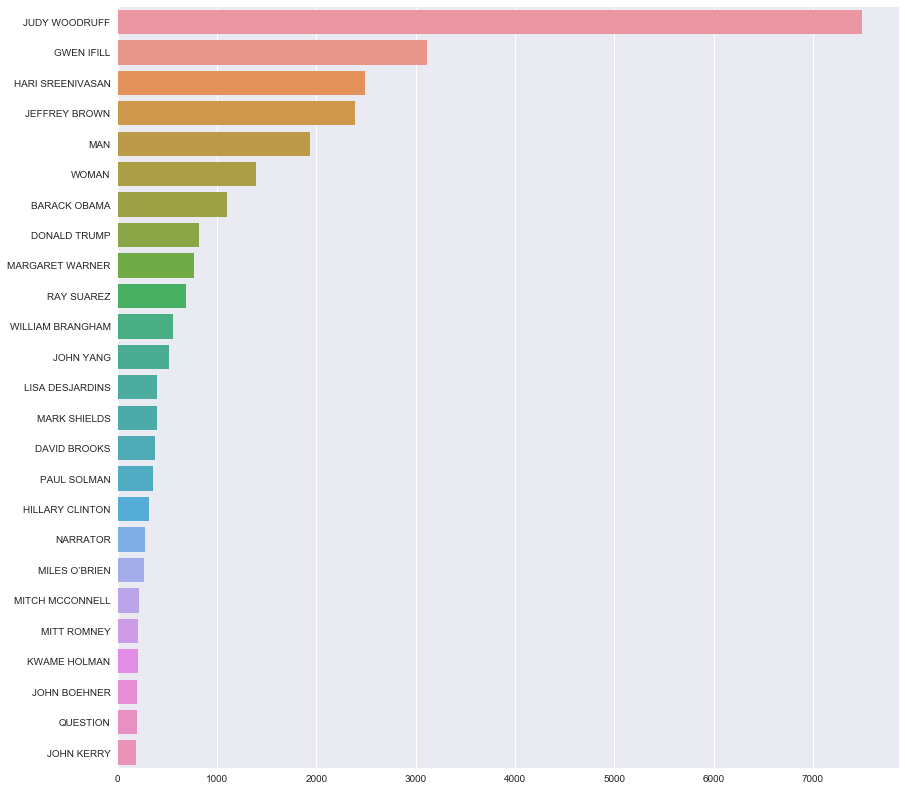

In [45]:
persons = pbs.Speakers.map(list).sum()

freq = sorted(Counter(persons).items(), key=operator.itemgetter(1), reverse=True)

x, y = list(zip(*freq[:25]))
plt.figure(figsize=(14, 14))
sns.barplot(list(y), list(x));

---
<a id="trends"></a>

# [^](#toc) Trends

<a id="topic_popularity"></a>

### [^](#toc) Topic Popularity

This shows the popularity of a word for a given month.  I measure the fraction of time a word is used for a particular story, then take the average value for a given month.

To look at the topic of a topic, multiple moving averages are performed to smooth out fluctuations.

There seems to be an increasing trend talking about immigration and racism.  Interestingly, PBS has no mention of racism until 2013.

In [14]:
LIMIT_TIME = True
topics     = ["Obama", "Trump", "Clinton", "Bush", "Immigration", "Congress", "Racism"]

def topic_popularity(topic):
    def popularity_helper(transcript):
        transcript = list(map(lambda x: x[1][0], transcript))
        transcript = (" ".join(transcript).lower()).split(" ")
        N          = len(transcript)
        counts     = Counter(transcript)
        return (counts[topic.lower()] / N) * 100
    return popularity_helper

if LIMIT_TIME:
    temp = pbs[pbs.Year > 2010]
else:
    temp = pbs

datas = []
for topic in tqdm(topics):
    temp["Temp"] = (
                temp[temp.Transcript.map(lambda x: x != [])]
                    .Transcript
                    .map(topic_popularity(topic))
                )

    data = (temp
         .set_index("Date")
         .groupby(pd.Grouper(freq="M"))
         .Temp
         .apply(np.mean)
    )

    trend = get_trend(data, ROLLING_WINDOW=12)

    datas.append((topic, data, trend))

traces = []

for topic, data, _ in datas:
    traces.append(go.Scatter(
                            x=data.index,
                            y=data.values,
                            name=f"{topic} - actual"
                        ))
    
for topic, _, trend in datas:
    traces.append(go.Scatter(
                            x=trend.index,
                            y=trend.values, 
                            name=f"{topic} - trend"
                        ))
buttons = []

for i, topic in enumerate(topics):
    visibility = [i==j for j in range(len(topics))]
    button = dict(
                 label =  topic,
                 method = 'update',
                 args = [{'visible': visibility},
                     {'title': f"'{topic}' usage over time" }])
    buttons.append(button)

updatemenus = list([
    dict(active=-1,
         x=-0.15,
         buttons=buttons
    )
])

layout = dict(title='Topic popularity', 
              updatemenus=updatemenus,
                xaxis=dict(title='Date'),
                yaxis=dict(title='Percent of words')
             )

fig = dict(data=traces, layout=layout)
fig['layout'].update(height=800, width=800)

iplot(fig)

100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


---

# <strong>Part II: Is News a Bad Movie?</strong>

I want to see how political sentiment changes over time.  However that's hard to quantify, how do I train whether.

### What is double jeopardy?

It does feel very stupid training a model on movie reviews.  In addition, I'm using naive bayes and word frequency analysis which is stupid in itself.  Models like this don't understand sarcasm, different word meanings, or phrases.  However we should be okay.

---

<a id="movies_setup"></a>

# [^](#toc) <u>Setup</u>

<a id="movies_load"></a>

### [^](#toc) Load data

In [15]:
train = pd.read_feather("data/movie_train.csv")
test  = pd.read_feather("data/movie_test.csv")

In [16]:
# train_dir = "data/large-movie-reviews/train/"
# test_dir  = "data/large-movie-reviews/test/"

# train = pd.DataFrame(columns=["Text", "Sentiment"])
# test  = pd.DataFrame(columns=["Text", "Sentiment"])

# for df, path in ([train, train_dir], [test, test_dir]):
#     for sent in ("pos", "neg"):
#         for txt in tqdm(glob.glob(path + sent + "/*")):
#             txt = open(txt, "r")

#             review = txt.read()
#             df.loc[len(df)] = [review, sent]

#             txt.close()

### OPTIONAL: Save time and feather the train and test data into a feathered CSV
# # train.to_feather("data/movie_train.csv")
# # test.to_feather("data/movie_test.csv")

# train.head()

<a id="movies_process"></a>

### [^](#toc) Process Data

In [17]:
train.Sentiment = train.Sentiment.map(lambda x: int(x == "pos"))
test.Sentiment  = test.Sentiment.map(lambda x: int(x == "pos"))

# Save memory space
train.Sentiment = train.Sentiment.astype(np.int8)
test.Sentiment  = test.Sentiment.astype(np.int8)

---
<a id="training"></a>


# [^](#toc) <u>Model training</u>

<a id="movies_clean"></a>

### [^](#toc) Clean Movie Reviews

In [18]:
bad_words  = (">AAARGH!<", "<<<<<<<<<<<< <<<<<<<<<<<<<<<<<<<< <<<<<<<<<<<<<<<<<<<<<<<< <<<<<<<",
             "<grin>", "(comedy)", "(horror)", "(Mr. Director)", "<<<sigh>>>", ">.<", "(<sp?)",
             "<http://rogerebert.suntimes.com/apps/pb,cs.dll/section?category=ANSWERMAN>",
             "<3", "-->", "===========>", "</3",
              ">>>>>>>>>>>>> >>>>>>>>>>>>>>>>> >>>>>>>>>>>>>>>>>>>>>> >>>>>>>> >>>>>>>",
             ":ZZZZZZZZZZzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz..............", "<=8",
             "Yaaaaaaaaaaaaaawwwwwwwwwwwwwwwwwnnnnnnnnnnnnn!", 
              ":=8O", "ZZZZZZZZzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...........",
             ">>> youtube.com/watch?v=cNVrMZX2kms",
             "<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=ANSWERMAN>")

html_words = ("<hr>", "<br /><br />", "<i>", "</i>", "<em>", "</em>", "<SPOILER>", "</SPOILER>",)

def clean_txt(txt, words):
    for word in words:
        txt = txt.replace(word, " ")
    txt = txt.replace("_", " ")
    txt = txt.strip()
    return txt

def clean_reviews(review):
    review = clean_txt(review, bad_words)
    review = clean_txt(review, html_words)
    return review
    
train.Text = train.Text.map(clean_reviews)
test.Text  = test.Text.map(clean_reviews)

<a id="vectorize_words"></a>

### [^](#toc) Vectorizing words

<u>DISCLAIMER</u>: I stole a lot of this code from [Anisotropic](https://www.kaggle.com/arthurtok) and his excellent [kernel](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial).

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

lemm = WordNetLemmatizer()

class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
    
# Storing the entire training text in a list
text = list(train.Text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.6, 
                                     min_df=20,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

<a id="split_train_test"></a>

### [^](#toc) Split into train, test

In [20]:
train_x = tf_vectorizer.transform(train.Text).toarray()
train_y = train.Sentiment

test_x  = tf_vectorizer.transform(test.Text).toarray()
test_y  = test.Sentiment

<a id="basic_model"></a>

### [^](#toc) Basic model

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()

gnb_model.fit(train_x, train_y)

score = gnb_model.score(test_x, test_y)
print(f"Naive Bayes score: {round(score * 100, 2)}%")

<a id="lgb_model"></a>

### [^](#toc) LGBM


Usually Naive Bayes is used for classification, but I see great results with Light Gradient Boosting.  Also instead of classification, I want to see a spectrum meaning the predictions will be some float in between 0 and 1.

I think using a spectrum is more interesting as it differeniates a really negative text from a slighly negative text.

In [21]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

training_x, val_x, training_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=17)

lgb_train = lgb.Dataset(data=training_x, label=training_y)
lgb_eval  = lgb.Dataset(data=val_x, label=val_y)

params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.03, 'num_leaves': 55, 'num_iteration': 2000, 'verbose': 0 ,
          'subsample':.9, 'max_depth':7, 'reg_alpha':20, 'reg_lambda':20, 
          'min_split_gain':.05, 'min_child_weight':1, "min_data_in_leaf": 40,
          "feature_fraction":0.5}

start = time.time()
lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
print("Training took {} seconds".format(round(time.time() - start)))

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.885519
[400]	valid_0's auc: 0.904419
[600]	valid_0's auc: 0.91233
[800]	valid_0's auc: 0.916617
[1000]	valid_0's auc: 0.919374
[1200]	valid_0's auc: 0.921255
[1400]	valid_0's auc: 0.922448
[1600]	valid_0's auc: 0.923493
Early stopping, best iteration is:
[1627]	valid_0's auc: 0.923625
Training took 86 seconds


<a id="lgb_score"></a>

### [^](#toc) Score of LGBM model

The LGBM model is considerably better than Naive Bayes!  More can be done to increase this score, but it's good enough for me!

In [22]:
# Predict
predictions = lgb_model.predict(test_x)
print("/nFirst 5 valus of predictions")
print(" ".join(predictions[:5].astype(str)))

# Turn probabilities into classification
preds       = (predictions > 0.5).astype(int)

# Check if predictions are correct and score
score       = (preds == test_y).astype(int)
score       = sum(score) / len(score)
print(f"LGBM score: {round(score * 100, 2)}%")

/nFirst 5 valus of predictions
0.6823096152655787 0.2563676280349399 0.754158275654756 0.7299133738366266 0.9163257142306617
LGBM score: 84.69%


<a id="pred_dist"></a>

### [^](#toc) Distribution of predictions

I want to look at the distribution of predictions to see if it is suitable for our purposes.

The most important plot here is the predictions by label.

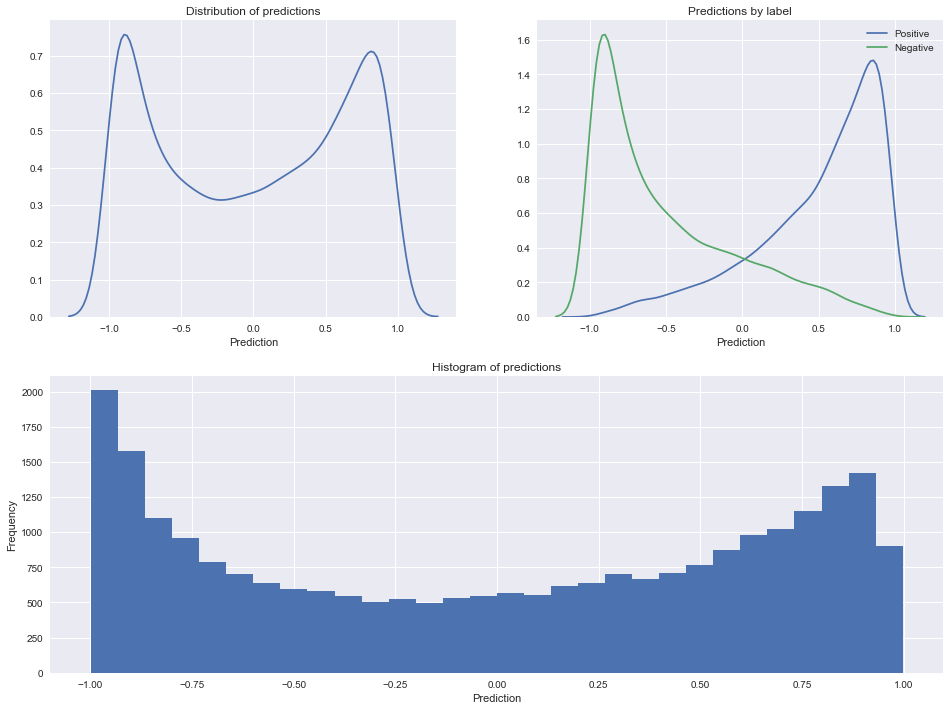

In [23]:
plt.figure(figsize=(16, 12))

### Nuanced way of creating subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

preds = (2 * predictions) - 1

# Left plot: KDE plot of predictions
ax1.set_title("Distribution of predictions")
ax1.set_xlabel("Prediction")
sns.kdeplot(preds, ax=ax1)

# Right plot: KDE plot of predictions by label 
pos_preds = preds[test_y[test_y == 1].index]
neg_preds = preds[test_y[test_y == 0].index]

ax2.set_title("Predictions by label")
ax2.set_xlabel("Prediction")
sns.kdeplot(pos_preds, label="Positive", ax=ax2)
sns.kdeplot(neg_preds, label="Negative", ax=ax2)

# Bottom plot: Histogram plot
ax3.set_title("Histogram of predictions")
ax3.set_xlabel("Prediction")
pd.DataFrame(preds).plot(kind="hist", bins=30, ax=ax3)
ax3.legend_.remove();

<a id="sent_analysis"></a>

# [^](#toc) <u>Sentiment Analysis</u>

<a id="speaker_sentiment"></a>

### [^](#toc) Sentiment by Speaker

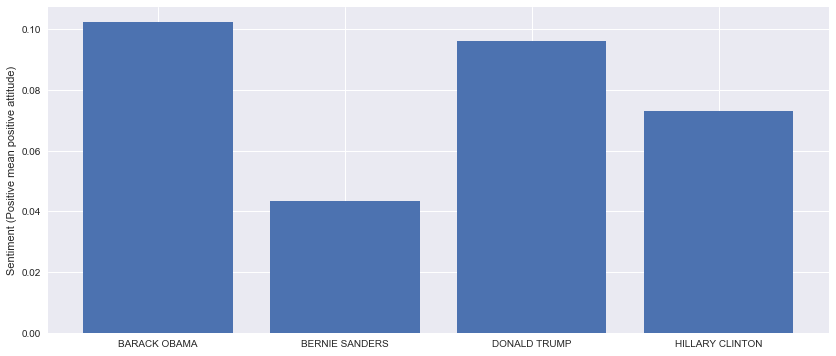

In [46]:
pois       = ["BERNIE SANDERS", "DONALD TRUMP", "HILLARY CLINTON", "BARACK OBAMA"] #, "LISA DESJARDINS", "DAVID BROOKS"]
pois_sents = dict()
poi_txts   = dict()

def get_speaker_text(df, poi):
    speaker_text = list()
    transcripts = df[df.Speakers.map(lambda x: poi in x)].Transcript.values
    
    for transcript in transcripts:
        total_txt = ""
        for person in transcript:
            if clean_names(person[0]) == poi:
                total_txt += " ".join(person[1]) + " "
        speaker_text.append(total_txt)
    return speaker_text

for poi in pois:
    txts       = get_speaker_text(pbs, poi)
    poi_txts[poi] = (txts)
    txts       = tf_vectorizer.transform(txts).toarray()
    sentiments = lgb_model.predict(txts)
    sentiments = (2 * sentiments) - 1
    pois_sents[poi] = sentiments

sents = [(poi, np.mean(sent)) for poi, sent in pois_sents.items()]
x, y  = list(zip(*sents))

plt.figure(figsize=(14, 6))
plt.ylabel("Sentiment (Positive mean positive attitude)")
plt.bar(x, y);

<a id="speaker_sentiment_extreme"></a>

### [^](#toc) Extreme Sentiments

From experience, I've seen Trump say very negative things so it's strange to see him with the same positivity of Obama.

I think it will be fruitful to compare the values in the 10% and 90% percentiles

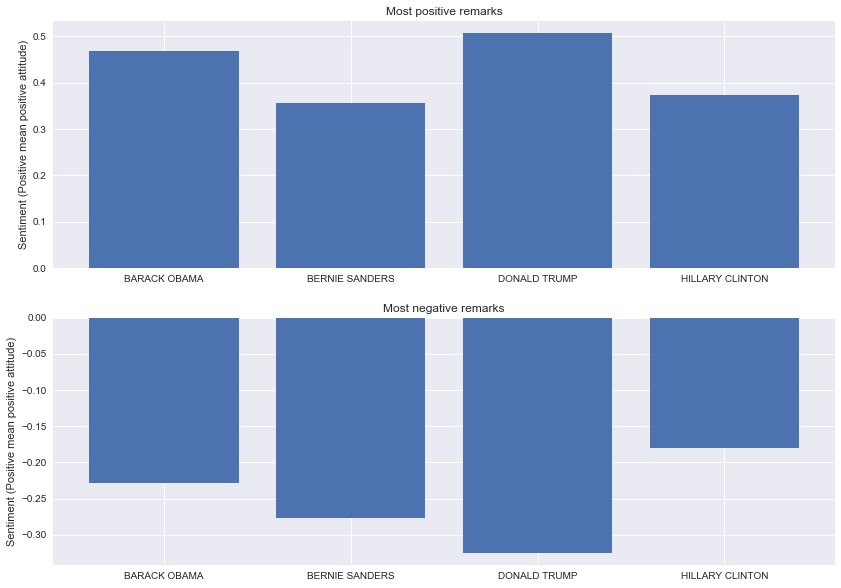

In [47]:
positive = [(poi, np.percentile(sent, 90)) for poi, sent in pois_sents.items()]
negative = [(poi, np.percentile(sent, 10)) for poi, sent in pois_sents.items()]

fig, axarr = plt.subplots(2, 1, figsize=(14, 10))

x, y  = list(zip(*positive))
axarr[0].set_title("Most positive remarks")
axarr[0].set(ylabel="Sentiment (Positive mean positive attitude)")
axarr[0].bar(x, y)

x, y  = list(zip(*negative))
axarr[1].set_title("Most negative remarks")
axarr[1].set_ylabel("Sentiment (Positive mean positive attitude)")
axarr[1].bar(x, y);

<a id="speaker_sentiment_kde"></a>

### [^](#toc) KDE Plots

This is a very interesting plot.  Notice how Trump is less likely to say something moderate.  Sanders has a small hump on the negative side.

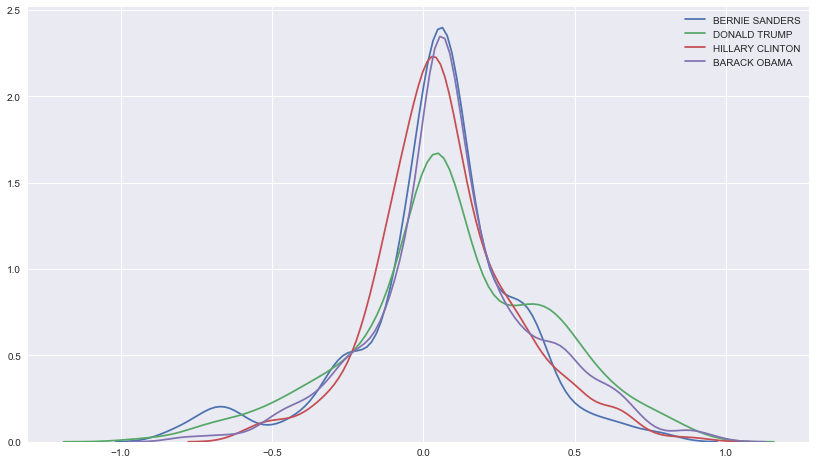

In [48]:
plt.figure(figsize=(14, 8))

all_sents = [(poi, sent) for poi, sent in pois_sents.items()]

for person, sentiment in all_sents:
    sns.kdeplot(sentiment, label=person)

<a id="speaker_sentiment_pos"></a>

### [^](#toc) Positive examples

The model is very accurate with Donald Trump and Barack Obama.  Almost every other word in Trump's text is positive.  The text from Obama is his State of the Union which was incredibly positive.

In [49]:
positive = [(poi, np.argmax(sent)) for poi, sent in pois_sents.items()]

for person, txt_index in positive:
    print(color.UNDERLINE, person, color.END)
    print(poi_txts[person][txt_index])
    print()

 BERNIE SANDERS 
 Great to be with you.  Well, I have been in the Democratic Caucus in the Senate for over 24 years. But, as an independent, my views, in fact, are a little bit different than many of my Democratic colleagues. I worry very much that we have a billionaire class now which has enormous power not only over our economy, but over our political system as well, as a result of Citizens United Supreme Court decision. So, my own view is that we have got to be very, very bold in taking on big money and creating a situation where government begins to work for the middle class and working families of our country, rather than just the wealthy and the powerful.  Judy, I’m running for president because, in my view, this country today, our country, faces more serious problems than at any time since the Great Depression. And if you throw in the planetary crisis of climate change, it may well be that the problems today are more severe. Look, for the last 40 years, the great middle class of

<a id="speaker_sentiment_neg"></a>

### [^](#toc) Negative Examples

Bernie Sanders and Donald Trump certainly sound like they just saw a bad movie.

The model seems to perform very well with Donald Trump and not so well with Hillary Clinton.  Trump uses a lot of adjectives and is very direct.  Hillary Clinton is somewhat less direct and a bit sarcastic which the model has trouble with.

In [50]:
negative = [(poi, np.argmin(sent)) for poi, sent in pois_sents.items()]

for person, txt_index in negative:
    print(color.UNDERLINE, person, color.END)
    print(poi_txts[person][txt_index])
    print()

 BERNIE SANDERS 
 Well, what went wrong, Judy, is they brought forth a disastrous health care bill that had the support of all of 12 percent of the American people, that was opposed by the American Medical Association, the American Hospital Association, the AARP. And virtually every national health care organization understood that, when you throw 22 million people off of health insurance, when you cut Medicaid by $800 billion, when you raise premiums for older workers, when you defund Planned Parenthood, and you make it almost impossible for people with preexisting conditions to get the health care they need and can afford, you know what? You have got a bill that’s a stinker, it shouldn’t go anyplace. And it didn’t go anyplace. And that’s a good thing for the American people. And I thank the millions of people who stood up and fought back and said that that legislation is not what this country is about.  Well, if he wants to blame me for helping kill that bill, I accept that responsib

<a id="topic_sentiment"></a>

### [^](#toc) Topic Sentiment

Are certain words associated with good or bad movies?  Look at articles with these words in their summary

In [56]:
topics = ["Obama", "Trump", "Clinton", "Bush", "Immigration", "Congress"]
Ns     = []



for topic in topics:
    stories = pbs[pbs.Story.map(lambda x: topic in x)]
    
    Ns.append(len(stories))
    

1537
1725
501
84
37
566


<a id="pbs_sentiment"></a>

### [^](#toc) PBS Sentiment

In [30]:
pbs_staff = ["JUDY WOODRUFF", "GWEN IFILL", "JOHN YANG",
             "RAY SUAREZ", "JIM LEHRER", "JEFFREY BROWN",
             "HARI SREENIVASAN"]

### Speakers

In [40]:
temp = pbs.Speakers.map(list).sum()
temp = Counter(temp)

In [59]:
temp.keys()

dict_keys(['FIDEL CASTRO', 'ROBERT MACNEIL', 'ROBERT HUGHES', 'PAUL SOLMAN', 'JIM LEHRER', 'LINDA ZALANOWSKI', 'RACHEL SMITH', 'JOE ZALANOWSKI', 'NITA KINMAN', 'WOMAN', 'CHILDREN', 'BOB MCLANE', 'BETTY ANN BOWSER', 'GENNY MCLANE', 'JULES HIRSCH', 'JOANN CHASE', 'LORRAINE M.', 'LOUIS ARONNE', 'SUSAN DENTZER', 'JULES HIRSCHA', 'ROBERT PINSKY', 'MAN', 'PIG FARMER', 'ELIZARDO SANCHEZ', 'STUDENT', 'SALESMAN', 'GISELLE CASTRO', 'ROLANDO CAMACHO', 'OMAR LINARES', 'JOSE ANTONIO SANCHEZ', 'SO', 'ALBERTO LOTTI', 'JUAN CARLOS', 'FRANCISCO SOBERON', 'ERMINIA VALENZUELA', 'LINCOLN DIAZBALART', 'PHIL GRAMM', 'MARTA BEATRIZ ROQUE', 'OH', 'RAY SUAREZ', 'BILLY COLLINS', 'BILL BELICHICK', 'ROBERT KRAFT', 'JONATHAN KRAFT', 'SCOTT PIOLI', 'SPOKESMAN', 'RICHARD ARMITAGE', 'ERIC KLINENBERG', 'MIKE MOSETTIG', 'INTERVIEWER', 'MIKE MOSETTING', 'JEFFREY BROWN', 'MIKE RAUPP', 'CHILD', 'PHILIP ROTH', 'GWEN MOORE', 'REDD', 'JASON DE PARLE', 'JASON TURNER', 'SPOKESPERSON', 'ANGIE JOBE', 'GWEN IFILL', 'KATHY SANTOYO

### Most common words on Movie Reviews

This code is copied from [Anisotropic](https://www.kaggle.com/arthurtok) and his excellent [kernel](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial).

In [44]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)